# Parking Simulator

[Casper Smet](https://github.com/Casper-Smet) & [Stan Meyberg](https://github.com/StanMey)

In this Jupyter Notebook we implement a discrete event system. The goal of this discrete event system is to simulate a garage. Using this simulation, we wish to gain some insight into the inner workings of a parking garage;

-Total income  
-Queue sizes throughout the day  
-Usage of parking spots throughout the day 

The garage we modelled is [Parking garage Gooiland](https://www.centrumparkeren.nl/hilversum/parkeergarages/gooiland).  
Peak times were based off of the neighbouring [supermarket]( https://www.google.com/search?q=albert+heijn+gooialdn&oq=albert+heijn+gooialdn&aqs=chrome..69i57j0l2.13159j0j4&sourceid=chrome&ie=UTF-8).  
Most constants defined in the following section were based off of these two locations.

In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### Declaring constants
Here we declare some constants for running the simulation. To run the simulation with other or changed values simply change the intented constant to the desired value and rerun the simulation.

In [2]:
RANDOM_SEED = 42
SIM_TIME = 24 * 60

# The day hours
DAY_MIN = 8 * 60
DAY_MAX = 18 * 60

# MINUTE rate
MINUTE_RATE = 0.2 / 5

# Max price day
DAY_PRICE = 8
# Max price night
NIGHT_PRICE = 5

# The peak hours
PEAK_MIN = 15 * 60   # 15:00
PEAK_MAX = 20 * 60   # 20:00

# The maximum capacity of the garage
MAX_CAPACITY = 364

# Constants for the amount of time a car is parked
MIN_CAR_PARK_TIME = 1
MAX_CAR_PARK_TIME = 60

# Constants for the time to find a spot
MIN_FINDING_SPOT = 1
MAX_FINDING_SPOT = 5

# Constants for the time to exit the garage
MIN_EXITING_TIME = 1
MAX_EXITING_TIME = 3

# Constants for the range of cars expected per minute outside peak hours
MIN_NON_PEAK_AMOUNT = 0
MAX_NON_PEAK_AMOUNT = 2

# Constants for the range of cars expected per minute inside peak hours
MIN_PEAK_AMOUNT = 1
MAX_PEAK_AMOUNT = 5

In [3]:
class Garage(object):
    def __init__(self, env, max_spots=MAX_CAPACITY):
        self.env = env
        self.spots = simpy.Resource(env, max_spots)
        self.taken_spots = []
        self.queue = []
        self.timestamps = []
        
        # Process simulation events
        self.env.process(self.process())
        
    def run(self, until_=SIM_TIME):
        """Runs the simulation"""
        self.env.run(until=until_)
    
    def spots_used(self):
        """Returns tuple with timestamp and amount of taken parking spots"""
        time = self.env.now
        spots = len(self.spots.users)
        self.taken_spots.append((time, spots))
        
    def size_of_queue(self):
        """Returns tuple with timestamp and amount of cars in the queue"""
        time = self.env.now
        queue = len(self.spots.queue)
        self.queue.append((time, queue))
        
        
    def car(self, name):
        """Details behaviour of a car"""
        time_of_arrival = self.env.now

        # Request one of the Garage's parking spots
        print('%s arriving at %d' % (name, self.env.now))
        with self.spots.request() as req:
            yield req

            time_of_assignment = self.env.now

            # Find spot
            print('%s finding parking spot %s' % (name, self.env.now))
            yield self.env.timeout(nrml_dist(MIN_FINDING_SPOT, MAX_FINDING_SPOT))

            # Park car
            print('%s starting to park %s' % (name, self.env.now))
            yield self.env.timeout(nrml_dist(MIN_CAR_PARK_TIME, MAX_CAR_PARK_TIME))

            # Leaving garage
            print('%s starting to leave %s' % (name, self.env.now))
            yield self.env.timeout(nrml_dist(MIN_EXITING_TIME, MAX_EXITING_TIME))

            # Left garage
            time_of_departure = self.env.now
            print('%s left %s' % (name, time_of_departure))

            # Append collected timestamps to self.timestamps
            self.timestamps.append((time_of_arrival, time_of_assignment, time_of_departure))
            
    def process(self):
        """Runs the process in the environment"""
        car_numb = 0
        
        while True:
        
            yield self.env.timeout(1)

            if (PEAK_MIN <= self.env.now <= PEAK_MAX):
                total_new_cars = new_cars_amount(True)
            else:
                total_new_cars = new_cars_amount(False)

            for i in range(total_new_cars):
                self.env.process(self.car(car_numb))
                car_numb += 1
            self.size_of_queue()
            self.spots_used()

In [4]:
def nrml_dist(min_, max_):
    """The function takes a minimal and maximal number and generates a number based on normal distribution"""
    mu = (max_ + min_) / 2
    sigma = mu / 3
    
    rd_numb = random.normalvariate(mu, sigma)
    
    if (rd_numb < min_):
        rd_numb = min_
    if (rd_numb > max_):
        rd_numb = max_
    
    return round(rd_numb)

In [5]:
def new_cars_amount(is_peak):
    """Returns amount of cars based on is_peak"""
    
    total_cars = 0
    
    if is_peak:
        total_cars = nrml_dist(MIN_PEAK_AMOUNT, MAX_PEAK_AMOUNT)
    else:
        total_cars = nrml_dist(MIN_NON_PEAK_AMOUNT, MAX_NON_PEAK_AMOUNT)
        
    return total_cars

In [6]:
def calc_price(ToA, ToD):
    """Calculates price based on: ToA: time of assignment, ToD: time of departure"""
    delta_t = abs(ToD - ToA)
    if DAY_MIN < ToA < DAY_MAX: 
    # Price inside the day interval
        price = delta_t * MINUTE_RATE
        if price > DAY_PRICE:
            price = DAY_PRICE
    else:
    # Price outside the day interval
        price = delta_t * MINUTE_RATE
        if price > NIGHT_PRICE:
            price = NIGHT_PRICE
    
    return round(price, 2)

In [7]:
# For repeatability of the simulation we choose a random seed
random.seed(RANDOM_SEED)

# Create the environment
env = simpy.Environment()
garage = Garage(env)

# Run the simulation
garage.run()

# Retrieve the generated information during the simulation
data = garage.timestamps
taken_spots = garage.taken_spots
queue_sizes = garage.queue

0 arriving at 1
0 finding parking spot 1
1 arriving at 2
1 finding parking spot 2
2 arriving at 3
2 finding parking spot 3
0 starting to park 4
3 arriving at 4
4 arriving at 4
3 finding parking spot 4
4 finding parking spot 4
1 starting to park 5
5 arriving at 5
6 arriving at 5
5 finding parking spot 5
6 finding parking spot 5
7 arriving at 6
7 finding parking spot 6
2 starting to park 7
3 starting to park 7
8 arriving at 7
8 finding parking spot 7
4 starting to park 8
6 starting to park 8
9 arriving at 8
9 finding parking spot 8
8 starting to park 9
10 arriving at 9
9 starting to park 9
10 finding parking spot 9
5 starting to park 10
7 starting to park 10
11 arriving at 10
11 finding parking spot 10
12 arriving at 11
12 finding parking spot 11
10 starting to park 13
11 starting to park 13
13 arriving at 13
13 finding parking spot 13
12 starting to park 14
13 starting to park 15
14 arriving at 15
14 finding parking spot 15
15 arriving at 16
15 finding parking spot 16
14 starting to par

219 finding parking spot 218
216 starting to park 219
176 left 219
220 arriving at 219
220 finding parking spot 219
217 starting to park 220
190 left 220
206 left 220
221 arriving at 220
220 starting to park 220
221 finding parking spot 220
183 starting to leave 221
218 starting to park 221
222 arriving at 221
222 finding parking spot 221
189 starting to leave 222
201 starting to leave 222
219 starting to park 222
221 starting to park 222
223 arriving at 222
223 finding parking spot 222
203 starting to leave 223
224 arriving at 223
224 finding parking spot 223
188 starting to leave 224
183 left 224
222 starting to park 224
201 left 224
225 arriving at 224
226 arriving at 224
225 finding parking spot 224
226 finding parking spot 224
189 left 225
223 starting to park 225
203 left 225
227 arriving at 225
226 starting to park 225
227 finding parking spot 225
188 left 226
225 starting to park 226
228 arriving at 226
228 finding parking spot 226
192 starting to leave 227
229 arriving at 227


450 finding parking spot 454
412 starting to leave 455
423 starting to leave 455
432 starting to leave 455
409 left 455
451 arriving at 455
451 finding parking spot 455
425 starting to leave 456
450 starting to park 456
452 arriving at 456
452 finding parking spot 456
419 starting to leave 457
428 starting to leave 457
449 starting to park 457
412 left 457
423 left 457
432 left 457
451 starting to park 457
453 arriving at 457
453 finding parking spot 457
454 arriving at 458
454 finding parking spot 458
400 starting to leave 459
425 left 459
452 starting to park 459
419 left 459
455 arriving at 459
454 starting to park 459
455 finding parking spot 459
424 starting to leave 460
426 starting to leave 460
428 left 460
456 arriving at 460
456 finding parking spot 460
453 starting to park 461
400 left 461
455 starting to park 461
424 left 461
457 arriving at 461
457 finding parking spot 461
426 left 462
456 starting to park 463
458 arriving at 463
458 finding parking spot 463
417 starting to

643 left 667
634 left 667
666 arriving at 667
666 finding parking spot 667
617 starting to leave 668
624 starting to leave 668
636 starting to leave 668
667 arriving at 668
667 finding parking spot 668
626 starting to leave 669
664 starting to park 669
665 starting to park 669
668 arriving at 669
668 finding parking spot 669
629 starting to leave 670
616 left 670
636 left 670
669 arriving at 670
669 finding parking spot 670
632 starting to leave 671
666 starting to park 671
617 left 671
624 left 671
667 starting to park 671
670 arriving at 671
669 starting to park 671
670 finding parking spot 671
633 starting to leave 672
655 starting to leave 672
626 left 672
668 starting to park 672
671 arriving at 672
671 finding parking spot 672
629 left 673
632 left 673
647 starting to leave 674
672 arriving at 674
672 finding parking spot 674
651 starting to leave 675
670 starting to park 675
633 left 675
655 left 675
673 arriving at 675
673 finding parking spot 675
674 arriving at 676
674 findin

905 arriving at 905
906 arriving at 905
903 finding parking spot 905
904 finding parking spot 905
905 finding parking spot 905
906 finding parking spot 905
901 starting to park 906
907 arriving at 906
908 arriving at 906
907 finding parking spot 906
908 finding parking spot 906
899 starting to park 907
900 starting to park 907
902 starting to park 907
903 starting to park 907
909 arriving at 907
910 arriving at 907
911 arriving at 907
909 finding parking spot 907
910 finding parking spot 907
911 finding parking spot 907
905 starting to park 908
906 starting to park 908
908 starting to park 908
912 arriving at 908
913 arriving at 908
914 arriving at 908
912 finding parking spot 908
913 finding parking spot 908
914 finding parking spot 908
877 starting to leave 909
904 starting to park 909
907 starting to park 909
909 starting to park 909
915 arriving at 909
916 arriving at 909
917 arriving at 909
918 arriving at 909
919 arriving at 909
915 finding parking spot 909
916 finding parking sp

1061 left 993
1112 left 993
1143 left 993
1161 arriving at 993
1162 arriving at 993
1157 starting to park 993
1161 finding parking spot 993
1162 finding parking spot 993
1073 starting to leave 994
1096 starting to leave 994
1151 starting to park 994
1032 left 994
1153 starting to park 994
1154 starting to park 994
1155 starting to park 994
1159 starting to park 994
1076 left 994
1163 arriving at 994
1164 arriving at 994
1165 arriving at 994
1163 finding parking spot 994
1164 finding parking spot 994
1165 finding parking spot 994
1097 starting to leave 995
1104 starting to leave 995
1160 starting to park 995
1034 left 995
1079 left 995
1166 arriving at 995
1167 arriving at 995
1166 finding parking spot 995
1167 finding parking spot 995
1064 starting to leave 996
1085 starting to leave 996
1120 starting to leave 996
1158 starting to park 996
1060 left 996
1093 left 996
1096 left 996
1168 arriving at 996
1169 arriving at 996
1168 finding parking spot 996
1169 finding parking spot 996
1020

1327 starting to leave 1086
1334 starting to leave 1086
1336 starting to leave 1086
1420 starting to park 1086
1422 starting to park 1086
1320 left 1086
1427 starting to park 1086
1428 starting to park 1086
1260 left 1086
1306 left 1086
1325 left 1086
1432 starting to park 1086
1439 arriving at 1086
1440 arriving at 1086
1441 arriving at 1086
1439 finding parking spot 1086
1440 finding parking spot 1086
1441 finding parking spot 1086
1301 starting to leave 1087
1316 starting to leave 1087
1313 starting to leave 1087
1377 starting to leave 1087
1341 left 1087
1431 starting to park 1087
1433 starting to park 1087
1335 left 1087
1437 starting to park 1087
1438 starting to park 1087
1278 left 1087
1442 arriving at 1087
1442 finding parking spot 1087
1329 starting to leave 1088
1430 starting to park 1088
1333 left 1088
1286 left 1088
1327 left 1088
1334 left 1088
1440 starting to park 1088
1316 left 1088
1313 left 1088
1443 arriving at 1088
1444 arriving at 1088
1445 arriving at 1088
1443 f

1582 left 1161
1677 arriving at 1161
1678 arriving at 1161
1679 arriving at 1161
1680 arriving at 1161
1681 arriving at 1161
1677 finding parking spot 1161
1678 finding parking spot 1161
1679 finding parking spot 1161
1680 finding parking spot 1161
1681 finding parking spot 1161
1532 starting to leave 1162
1531 starting to leave 1162
1564 starting to leave 1162
1574 starting to leave 1162
1668 starting to park 1162
1672 starting to park 1162
1674 starting to park 1162
1507 left 1162
1569 left 1162
1682 arriving at 1162
1683 arriving at 1162
1684 arriving at 1162
1682 finding parking spot 1162
1683 finding parking spot 1162
1684 finding parking spot 1162
1575 starting to leave 1163
1585 starting to leave 1163
1638 starting to leave 1163
1673 starting to park 1163
1551 left 1163
1543 left 1163
1554 left 1163
1624 left 1163
1677 starting to park 1163
1531 left 1163
1564 left 1163
1574 left 1163
1685 arriving at 1163
1686 arriving at 1163
1687 arriving at 1163
1688 arriving at 1163
1682 st

1827 starting to leave 1253
1835 starting to leave 1253
1860 starting to park 1253
1866 arriving at 1253
1866 finding parking spot 1253
1864 starting to park 1254
1827 left 1254
1867 arriving at 1254
1867 finding parking spot 1254
1832 starting to leave 1255
1865 starting to park 1255
1835 left 1255
1868 arriving at 1255
1868 finding parking spot 1255
1818 starting to leave 1256
1866 starting to park 1256
1867 starting to park 1256
1869 arriving at 1256
1869 finding parking spot 1256
1815 starting to leave 1257
1821 starting to leave 1257
1870 arriving at 1257
1870 finding parking spot 1257
1819 starting to leave 1258
1832 left 1258
1869 starting to park 1258
1871 arriving at 1258
1871 finding parking spot 1258
1868 starting to park 1259
1818 left 1259
1815 left 1259
1821 left 1259
1872 arriving at 1259
1872 finding parking spot 1259
1834 starting to leave 1260
1819 left 1260
1873 arriving at 1260
1873 finding parking spot 1260
1849 starting to leave 1261
1870 starting to park 1261
187

## Analysing the simulation

In [8]:
received_money = list(map(lambda x : calc_price(x[1], x[2]), data))
print("total money received: {0}".format(round(sum(received_money), 2)))

total money received: 2897.24


In [9]:
car_waiting_time = list(map(lambda x : abs(x[1] - x[0]), data))
print("Average waiting time: {0}".format(np.mean(car_waiting_time)))

Average waiting time: 0.0


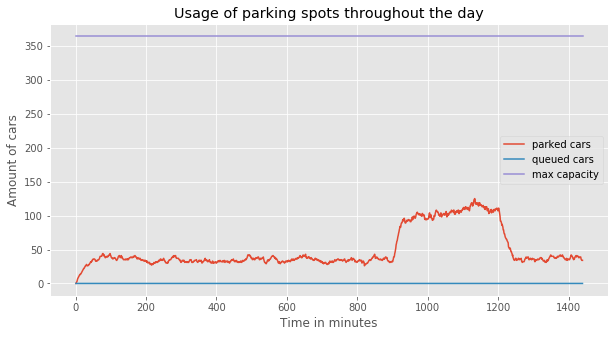

In [10]:
queue = np.array(queue_sizes).T
taken_spots = np.array(taken_spots).T

plt.rcParams['figure.figsize'] = [10,5]

plt.plot(taken_spots[0], taken_spots[1], label="parked cars")
plt.plot(queue[0], queue[1], label="queued cars")
plt.plot([0, SIM_TIME], [MAX_CAPACITY, MAX_CAPACITY], label="max capacity")

plt.title("Usage of parking spots throughout the day")
plt.xlabel("Time in minutes")
plt.ylabel("Amount of cars")

plt.legend()
plt.show()